In [1]:
import anndata
import pandas as pd
from itertools import product
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import scanpy as sc
import re
from scipy.stats import ks_2samp, ttest_ind
import scipy.stats as stats

In [68]:
#path to the normalized single cell data
#single_cell_expression_path='../data/h5ad/normed_uniprot_isoform.h5ad'
single_cell_expression_path='/home/yuxuans/scRNA-AlphaFold/data/h5ad/normed_swiss.h5ad'
#isoform reference summary
all_reference_path='/home/yuxuans/scRNA-AlphaFold/data/csv/reference_all.csv'
all_isoform_path='/home/yuxuans/scRNA-AlphaFold/data/csv/isoform_all.csv'
#cell count
cell_count_path='/home/yuxuans/scRNA-AlphaFold/data/csv/cell_type_count.csv'
#path to swissport isoform expression and the gene expression from samrtseq2  
smartseq2_path='/scratch/welchjd_root/welchjd0/yuxuans/temp/smartseq_TabulaSapiens.h5ad'

<span style="font-size: 20px;">Differential expression for the isoform in each cell type: </span>

# reference: 
Booeshaghi, A. Sina, et al. "Isoform cell-type specificity in the mouse primary motor cortex." Nature 598.7879 (2021): 195-199.
https://github.com/pachterlab/BYVSTZP_2020

In [14]:
single_cell_expression=anndata.read(single_cell_expression_path)

In [15]:
#remove duplicate entry
PAR_Y_list=[]
for gene_id in list(set(single_cell_expression.var['gene_ID'])):
    if 'PAR_Y' in gene_id:
        PAR_Y_list.append(gene_id)
single_cell_expression = single_cell_expression[:,~single_cell_expression.var['gene_ID'].isin(PAR_Y_list)]

In [16]:
#remove transcript only have one modeled uniprot entry
single_cell_expression = single_cell_expression[:,single_cell_expression.var['uniprot']!='Q6EEV4-2']
single_cell_expression = single_cell_expression[:,single_cell_expression.var['uniprot']!='Q8N726-1']
single_cell_expression = single_cell_expression[:,single_cell_expression.var['uniprot']!='Q9Y5P8-1']

In [17]:
#correct_name only within genes
single_cell_expression.var['gene_name'] = single_cell_expression.var['gene_name'].cat.add_categories(['NRXN1_P58400','CDKN2A_Q8N726','DUSP13_Q6B8I1','DUSP13_Q9UII6','POLR2M_Q6EEV4','BBC3_Q9BXH1','BBC3_Q96PG8','GNAS_P63092','GNAS_Q5JWF2'])
for index in range(len(single_cell_expression.var)):
    if single_cell_expression.var['uniprot'][index].split('-')[0]=='P58400':
        single_cell_expression.var['gene_name'][index]='NRXN1_P58400'
    elif single_cell_expression.var['uniprot'][index].split('-')[0]=='Q8N726':
        single_cell_expression.var['gene_name'][index]='CDKN2A_Q8N726'
    elif single_cell_expression.var['uniprot'][index].split('-')[0]=='Q6B8I1':
        single_cell_expression.var['gene_name'][index]='DUSP13_Q6B8I1'
    elif single_cell_expression.var['uniprot'][index].split('-')[0]=='Q9UII6':
        single_cell_expression.var['gene_name'][index]='DUSP13_Q9UII6'
    elif single_cell_expression.var['uniprot'][index].split('-')[0]=='Q6EEV4':
        single_cell_expression.var['gene_name'][index]='POLR2M_Q6EEV4'
    elif single_cell_expression.var['uniprot'][index].split('-')[0]=='Q9BXH1':
        single_cell_expression.var['gene_name'][index]='BBC3_Q9BXH1'
    elif single_cell_expression.var['uniprot'][index].split('-')[0]=='Q96PG8':
        single_cell_expression.var['gene_name'][index]='BBC3_Q96PG8'
    elif single_cell_expression.var['uniprot'][index].split('-')[0]=='P63092':
        single_cell_expression.var['gene_name'][index]='GNAS_P63092'
    elif single_cell_expression.var['uniprot'][index].split('-')[0]=='Q5JWF2':
        single_cell_expression.var['gene_name'][index]='GNAS_Q5JWF2'
    elif single_cell_expression.var['uniprot'][index]=='Q86UD7-2':
        single_cell_expression.var['gene_name'][index]='TBC1D26'


/tmp/ipykernel_1709525/3269525777.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  single_cell_expression.var['gene_name'] = single_cell_expression.var['gene_name'].cat.add_categories(['NRXN1_P58400','CDKN2A_Q8N726','DUSP13_Q6B8I1','DUSP13_Q9UII6','POLR2M_Q6EEV4','BBC3_Q9BXH1','BBC3_Q96PG8','GNAS_P63092','GNAS_Q5JWF2'])


In [18]:
#deff on cell type level
mat           = single_cell_expression.layers['log1p'].todense()
components    = single_cell_expression.obs.index.values
genes         = single_cell_expression.var['gene_name'].values
uniprot_isoform    = single_cell_expression.var['uniprot'].values
uniprot_class = single_cell_expression.var['class'].values
assignments   = single_cell_expression.obs['cell_ontology_class'].values

In [19]:
unique = np.unique(assignments)
nan_cutoff = 0 # of elements in cluster
#corr_method = "bonferroni"

In [20]:
unique = np.unique(assignments)
ncomp = components.shape[0]
ngenes = genes.shape[0]
nuniq = unique.shape[0]
pval = np.empty((nuniq, ngenes))
expression= np.empty((nuniq, ngenes))
stat = np.empty((nuniq, ngenes))
fc = np.empty((nuniq, ngenes))
stat.fill(np.nan)
fc.fill(np.nan)

In [21]:
def split_by_target(mat, targets, target, axis=0):
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
    mask = targets == target
    if axis==0:
        t_mat = mat[mask] 
        c_mat = mat[~mask]
    elif axis==1:
        t_mat = mat[:, mask] 
        c_mat = mat[:, ~mask]     
    return (t_mat, c_mat)

In [22]:
def split_by_target_within_genes(mat,genes,uniprot_isoform,gene,isoform):
    #first let mask_1 equal to genes, then let mask_1 equal to the target to see whether it's true or false
    mask_1=genes==gene
    sub_mat = mat[:,mask_1]
    entry=isoform.split('-')[0]
    uniprot_list = pd.Series(list(filter(lambda x: re.match(entry+'.*', x) != None, uniprot_isoform)))
    mask_2=uniprot_list==isoform
    t_mat = sub_mat[:, mask_2]  
    c_mat = sub_mat[:, ~mask_2] 
    return (t_mat, c_mat)

In [23]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [24]:
comparsion_count=0
for index in range(len(uniprot_isoform)):
    t_mat, c_mat = split_by_target_within_genes(mat, genes,uniprot_isoform,genes[index],uniprot_isoform[index])
    for tidx, t in enumerate(unique):
        isoform_mat= split_by_target(t_mat, assignments, t, axis=0)[0]
        other_mat=split_by_target(c_mat, assignments, t, axis=0)[0]
        pvalue = np.nan
        statistic = np.nan
        fold_change = 0
        if np.sum(isoform_mat)!=0 or np.sum(other_mat)!=0:
            if other_mat.shape[1]==1:
                statistic, pvalue = ttest_ind(isoform_mat, other_mat, nan_policy="propagate")
            else:
                nonzero_cols = np.any(other_mat, axis=0)
                nonzero_indices = np.where(nonzero_cols)[1]
                other_mat = other_mat[:, nonzero_indices]
                if other_mat.shape[1]==1:
                    statistic, pvalue = ttest_ind(isoform_mat, other_mat, nan_policy="propagate")
                else:
                    statistic, pvalue = stats.f_oneway(isoform_mat,other_mat.reshape(-1,1))
            comparsion_count+=1
        fold_change = np.mean(isoform_mat)/np.mean(other_mat)
        expression[tidx,index]=np.mean(isoform_mat)
        pval[tidx,index]= pvalue
        stat[tidx,index] = statistic
        fc[tidx,index] = fold_change

/tmp/ipykernel_1709525/1700980788.py:22: RuntimeWarning: invalid value encountered in double_scalars
  fold_change = np.mean(isoform_mat)/np.mean(other_mat)
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/stats/stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '
/home/yuxuans/.local/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:445: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/yuxuans/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yuxuans/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuxuans/.local/lib/python3.9/site-packages/numpy/core/_

In [25]:
p_raw = pval/2
p_corr=np.minimum(p_raw*comparsion_count, 1.0)

In [26]:
def make_table(assignments, genes, uniprot, p_raw, p_corr, fc, uniprot_class,expression):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["gene_name", "uniprot","uniprot_class","p_raw", "p_corr","fc","expression"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["gene_name"] = genes
        markers.loc[u]["uniprot"] = uniprot
        markers.loc[u]["uniprot_class"]=uniprot_class
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["fc"] = fc[uidx]
        markers.loc[u]["expression"] = expression[uidx]
    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    return markers

In [27]:
markers_isoform = make_table(assignments, genes, uniprot_isoform, p_raw, p_corr, fc, uniprot_class,expression)

In [88]:
def sign_isoform_within_gene(markers_table,alpha=0.05):
    markers_table=markers_table.sort_values(by=['gene_name'])
    entry_s=markers_table.query(f"p_corr < {alpha}").reset_index(drop=True)
    entry_ns=markers_table.query(f"p_corr > {alpha}").reset_index(drop=True)
    return entry_s,entry_ns
entry_s,entry_ns=sign_isoform_within_gene(markers_isoform,alpha=0.05)

In [89]:
def up_down_regulate(entry_sign):
    entry_up=entry_sign.query("fc > 1").reset_index(drop=True)
    entry_down=entry_sign.query("fc <= 1").reset_index(drop=True)
    return entry_up,entry_down
entry_up,entry_down=up_down_regulate(entry_s)

In [90]:
def subset_genes(entry_up):
    gene_list=[]
    co_expressed_list=[]
    for gene in entry_up['gene_name'].unique():
        gene_df=entry_up[entry_up['gene_name']==gene]
        #select genes with multiplee isoforms differentially expressed in not only one cell type
        if len(set(gene_df['uniprot']))!=1 and len(set(gene_df['index']))!=1:
            #if some isoforms significantly expressed in all cell types,then removed
            if (gene_df['uniprot'].value_counts()==133).all()==True:
                co_expressed_list.append(gene)
            else:
                gene_list.append(gene)
    genes_df=entry_up[entry_up['gene_name'].isin(gene_list)]
    return gene_list,co_expressed_list,genes_df.reset_index(drop=True)
gene_list,co_expressed_list,genes_df=subset_genes(entry_up)


In [91]:
def get_cell_type_dic(genes_df,gene_name):
    gene_df=genes_df[genes_df['gene_name']==gene_name]
    uniprot_list=list(set(gene_df['uniprot']))
    cell_type_dic={}
    for isoform in uniprot_list:
        cell_type_list=list(gene_df[gene_df['uniprot']==isoform]['index'])
        cell_type_dic[isoform]=sorted(cell_type_list)
    sorted_cell_type_dic = dict(sorted(cell_type_dic.items(), key=lambda x:len(x[1]),reverse=True))
    return sorted_cell_type_dic

In [92]:
#filter isoform expression in cell types with low expression (different from the following plot part, the expression is significant)
expression_gene=genes_df[genes_df['expression']>1].sort_values('fc',ascending=False).reset_index(drop=True)

In [93]:
all_reference=pd.read_csv(all_reference_path)
all_isoform=pd.read_csv(all_isoform_path)
cell_count=pd.read_csv(cell_count_path)

In [94]:
#combine plddt, cell count, transcript ID, gene ID
reference_plddt=dict(zip(list(all_reference['reference']),list(all_reference['plddt'])))
isoform_plddt=dict(zip(list(all_isoform['isoform']),list(all_isoform['plddt'])))
reference_transcript_ID=dict(zip(list(all_reference['reference']),list(all_reference['transcript_ID'])))
isoform_transcript_ID=dict(zip(list(all_isoform['isoform']),list(all_isoform['transcript_ID'])))
reference_gene_ID=dict(zip(list(all_reference['reference']),list(all_reference['gene_ID'])))
isoform_gene_ID=dict(zip(list(all_isoform['isoform']),list(all_isoform['gene_ID'])))
transcript_ID_list=[]
gene_ID_list=[]
plddt_list=[]
cell_count_list=[]

for index in range(len(expression_gene)):
    if expression_gene['uniprot_class'][index]=='reference':
        reference=expression_gene['uniprot'][index].split('-')[0]
        transcript_ID_list.append(reference_transcript_ID[reference])
        gene_ID_list.append(reference_gene_ID[reference])
        if reference in reference_plddt.keys():
            plddt_list.append(reference_plddt[reference])
        else:
            plddt_list.append(0)
    else:
        isoform=expression_gene['uniprot'][index]
        transcript_ID_list.append(isoform_transcript_ID[isoform])
        gene_ID_list.append(isoform_gene_ID[isoform])
        if isoform in isoform_plddt.keys():
            plddt_list.append(isoform_plddt[isoform])
        else:
            plddt_list.append(0)
    cell_type_count=cell_count[cell_count['cell type']==expression_gene['index'][index]].reset_index(drop=True)['cell count'][0]
    cell_count_list.append(cell_type_count)
expression_gene['plddt']=plddt_list    
expression_gene['transcript_ID']=transcript_ID_list
expression_gene['gene_ID']=gene_ID_list
expression_gene['cell_type_count']=cell_count_list

In [95]:
expression_gene_high_confident=expression_gene[expression_gene['plddt']>70].reset_index(drop=True)
gene_list,co_expressed_list,expression_gene_high_confident=subset_genes(expression_gene_high_confident)
expression_gene_high_confident_cell=expression_gene_high_confident[expression_gene_high_confident['cell_type_count']>30].reset_index(drop=True)
gene_list,co_expressed_list,expression_gene_high_confident_cell=subset_genes(expression_gene_high_confident_cell)

In [96]:
def remove_gene(expression_gene):
    remove_gene_list=[]
    for gene in list(set(expression_gene['gene_name'])):
        cell_type_dic=get_cell_type_dic(expression_gene,gene)
        all_values = list(cell_type_dic.values())
        shared_values = list(set(all_values[0]).intersection(*all_values))
        for isoform in cell_type_dic.keys():
            if set(cell_type_dic[isoform])==set(shared_values) and len(cell_type_dic)==2:
                remove_gene_list.append(gene)
    expression_gene_removed=expression_gene[~expression_gene['gene_name'].isin(remove_gene_list)].reset_index(drop=True)
    return expression_gene_removed

In [97]:
expression_gene_high_confident_cell_corrected=remove_gene(expression_gene_high_confident_cell)

<span style="font-size: 20px;">Plot for single cell differential expression: </span>

In [99]:
sc_diff=expression_gene_high_confident_cell_corrected
sc_all=markers_isoform

In [72]:
#sc_diff=pd.read_csv(sc_diff_path)
#sc_all=pd.read_csv(sc_all_path)

In [41]:
def generate_combinations(df, column1, column2):
    for value1, value2 in product(set(df[column1]), set(df[column2])):
        yield value1, value2

In [100]:
#This will include the isoform expression in cell types which may not be significant
def add_expression_cell_type(cell_type_diff,cell_type_all,single_cell_expression):
    new_cell_type_diff = cell_type_diff.drop(columns=['plddt','cell_type_count','transcript_ID','gene_ID'])
    new_index=len(new_cell_type_diff)
    existing_combinations = list(zip(cell_type_diff['index'], cell_type_diff['uniprot']))
    combinations_generator = generate_combinations(cell_type_diff,'index', 'uniprot')
    for cell_type,uniprot in combinations_generator:
        cell_type_uniprot=(cell_type,uniprot)
        if cell_type_uniprot not in existing_combinations:

            row=cell_type_all[(cell_type_all['index']==cell_type) & (cell_type_all['uniprot']==uniprot)]
            if row.empty == False:
                new_cell_type_diff.loc[new_index]=row.iloc[0]
                new_index+=1
            else:
                uniprot_anndata=single_cell_expression[single_cell_expression.obs['cell_ontology_class']==cell_type,
                       single_cell_expression.var['uniprot']==uniprot]
                expression=np.mean(uniprot_anndata.layers['log1p'])
                uniprot_class=uniprot_anndata.var['class'][0]
                gene_name=uniprot_anndata.var['gene_name'][0]
                temp_list=[cell_type,gene_name,uniprot,uniprot_class,0,0,0,expression]
                new_cell_type_diff.loc[new_index]=temp_list
                new_index+=1
    new_cell_type_diff=new_cell_type_diff.drop_duplicates()
    return new_cell_type_diff
sc_diff_ex=add_expression_cell_type(sc_diff,sc_all,single_cell_expression)

In [101]:
#some have differential between isoforms, therefore add reference for comparsion
def add_reference(cell_type_diff,cell_type_all,single_cell_expression):
    new_cell_type_diff=cell_type_diff.copy()
    new_index=len(new_cell_type_diff)
    cell_type_list=list(set(list(new_cell_type_diff['index'])))
    for gene_name in set(list(new_cell_type_diff['gene_name'])):
        gene=new_cell_type_diff[new_cell_type_diff['gene_name']==gene_name].reset_index(drop=True)
        if 'reference' not in list(gene['uniprot_class']) and gene_name!='gene_name':
            for cell_type in cell_type_list:
                row=cell_type_all[(cell_type_all['index']==cell_type) & 
                                  (cell_type_all['uniprot_class']=='reference') &
                                  (cell_type_all['gene_name']==gene_name)]

                if row.empty == False:
                    new_cell_type_diff.loc[new_index]=row.iloc[0]
                    new_index+=1
                else:
                    cell_type_expression=single_cell_expression[single_cell_expression.obs['cell_ontology_class'] == cell_type]
                    reference_genes = single_cell_expression.var[(single_cell_expression.var['gene_name'] == gene_name) 
                                                                & (single_cell_expression.var['class'] == 'reference')]
                    uniprot_anndata=single_cell_expression[cell_type_expression.obs.index, reference_genes.index]
                    uniprot=uniprot_anndata.var['uniprot'][0]
                    expression=np.mean(uniprot_anndata.layers['log1p'])
                    temp_list=[cell_type,gene_name,uniprot,'reference',0,0,0,expression]
                    new_cell_type_diff.loc[new_index]=temp_list
                    new_index+=1
    new_cell_type_diff=new_cell_type_diff.drop_duplicates()
    return new_cell_type_diff

In [102]:
sc_diff_ex_new=add_reference(sc_diff_ex,sc_all,single_cell_expression)

In [103]:
#filter gene has lower than 0.3 expression for each gene, since we add some isoform expreesion for each gene, which may not significant 
def filter_low_expression(cell_type_diff):
    new_cell_type_diff=cell_type_diff.copy()
    low_expression_list=[]
    for gene_name in set(list(new_cell_type_diff['gene_name'])):
        gene=new_cell_type_diff[new_cell_type_diff['gene_name']==gene_name].reset_index(drop=True)
        expression=np.mean(gene['expression'])
        if expression<0.3:
            low_expression_list.append(gene_name)
    mask = ~new_cell_type_diff['gene_name'].isin(low_expression_list)
    new_cell_type_diff = new_cell_type_diff[mask].reset_index(drop=True)
    return new_cell_type_diff
sc_diff_ex_new=filter_low_expression(sc_diff_ex_new)

In [104]:
def add_plot_name(cell_type_diff):
    new_cell_type_diff=cell_type_diff.copy()
    new_cell_type_diff['plot_name']='na'
    max_length_element = cell_type_diff['gene_name'].str.len().idxmax()
    max_length_value = cell_type_diff['gene_name'].iloc[max_length_element]
    max_length=len(max_length_value)
    for index in range(len(new_cell_type_diff)):
        gene_name=new_cell_type_diff['gene_name'][index]
        uniprot=new_cell_type_diff['uniprot'][index]
        uniprot_class=new_cell_type_diff['uniprot_class'][index]
        if uniprot_class=='isoform':
            new_cell_type_diff['plot_name'][index]=gene_name+'_'+'I'+'-'+uniprot.split('-')[1]
        else:
            new_cell_type_diff['plot_name'][index]=gene_name+'_'+'R'+'-'+uniprot.split('-')[1]
    return new_cell_type_diff
sc_diff_ex_new=add_plot_name(sc_diff_ex_new)

In [105]:
def cluster_gene_set_order(cell_type_diff):
    new_cell_type_diff=cell_type_diff.copy()
    summed_df = cell_type_diff.groupby('gene_name')['expression'].sum().reset_index()
    summed_df = summed_df.sort_values(by='expression', ascending=True).reset_index(drop=True)
    gene_order_list=list(summed_df['gene_name'])
    new_cell_type_diff['gene_name'] = pd.Categorical(cell_type_diff['gene_name'], categories=gene_order_list, ordered=True)
    new_cell_type_diff =  new_cell_type_diff.sort_values(by='gene_name').reset_index(drop=True)
    seen = set()
    gene_name_list=[]
    for gene_name in list(new_cell_type_diff['gene_name']):
        if gene_name not in seen:
            seen.add(gene_name)
            gene_name_list.append(gene_name)
    plot_name_list=[]
    for gene_name in gene_name_list:
        reference=new_cell_type_diff[(new_cell_type_diff['gene_name']==gene_name) & 
                                (new_cell_type_diff['uniprot_class']=='reference')].reset_index(drop=True)
        plot_name_list.append(reference['plot_name'].unique()[0])
        
        isoform=new_cell_type_diff[(new_cell_type_diff['gene_name']==gene_name) & 
                                (new_cell_type_diff['uniprot_class']=='isoform')].reset_index(drop=True)
        for isoform in isoform['plot_name'].unique():
            plot_name_list.append(isoform)
    return plot_name_list
plot_name_list=cluster_gene_set_order(sc_diff_ex_new)

In [106]:
heatmap_data = sc_diff_ex_new.pivot(index='index', columns='plot_name', values='expression')
heatmap_data = heatmap_data.reindex(columns=plot_name_list)

In [107]:
heatmap_data=heatmap_data.astype('float64')

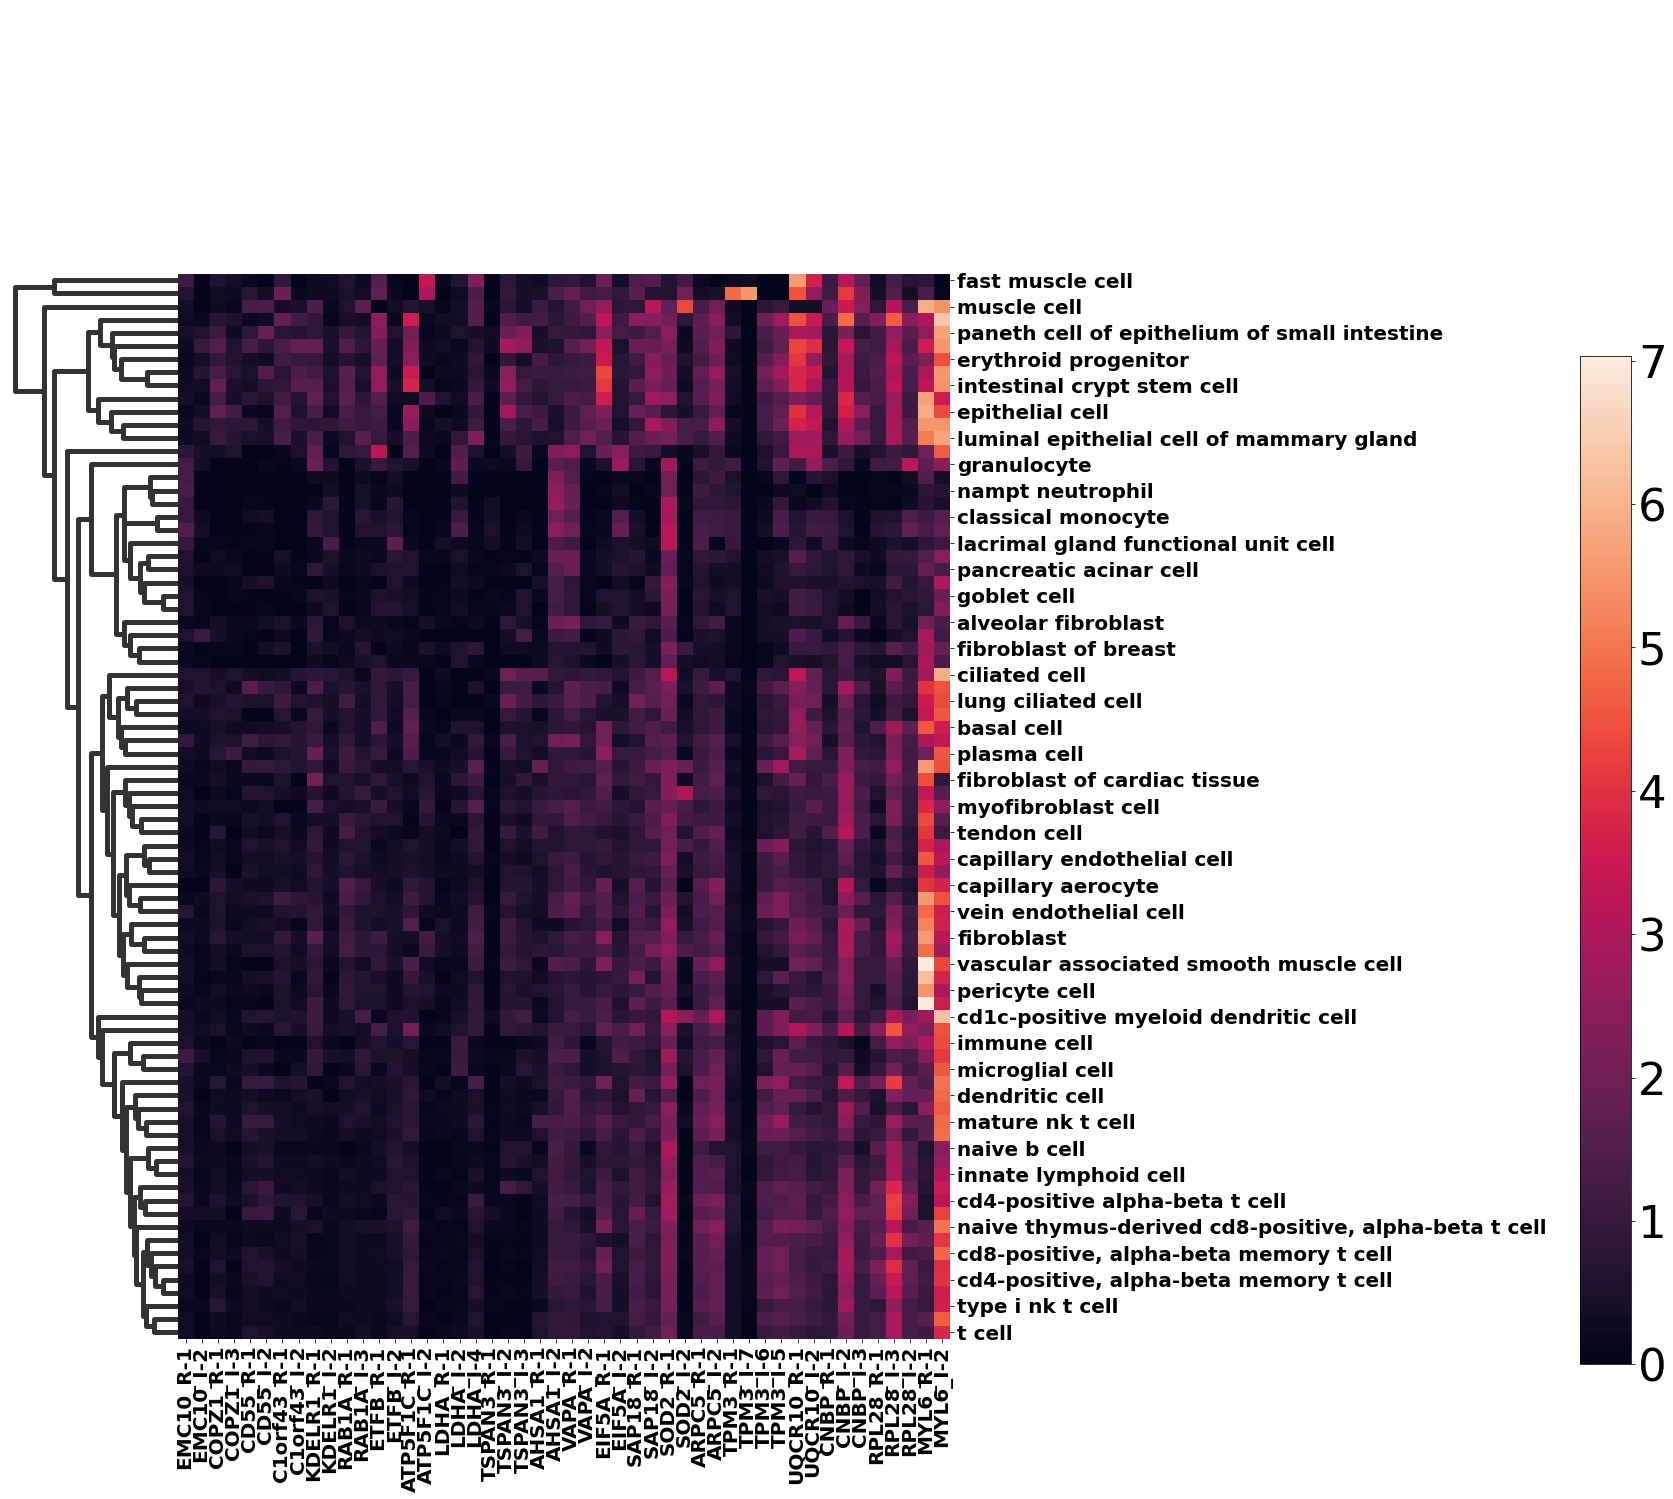

In [119]:
font = FontProperties(weight='bold')
clustergrid=sns.clustermap(heatmap_data,figsize=(20,20),dendrogram_ratio=(.15, .2),
                           tree_kws=dict(linewidths=5),col_cluster=False)
#color bar
clustergrid.cax.set_visible(False)
#colorbar = clustergrid.cax
cbar = plt.colorbar(clustergrid.ax_heatmap.collections[0], ax=clustergrid.ax_heatmap)
cbar.ax.tick_params(labelsize=45)
cbar.ax.set_position([1.1,0.05, 0.06,0.7])
#colorbar.set_title('Expression Level', fontsize=50)
clustergrid.ax_heatmap.set_xticklabels(clustergrid.ax_heatmap.get_xticklabels(), fontsize=20,fontproperties=font)
clustergrid.ax_heatmap.set_yticklabels(clustergrid.ax_heatmap.get_yticklabels(), fontsize=20,fontproperties=font)
#clustergrid.ax_heatmap.tick_params(axis='both', which='both',fontproperties=font)
clustergrid.ax_heatmap.set_xlabel('')
clustergrid.ax_heatmap.set_ylabel('')
#plt.savefig('heatmap_colorbar.png',dpi=500,bbox_inches='tight')
#clustergrid.ax_heatmap.set_yticklabels('Cell type', fontsize=50)
plt.show()

<span style="font-size: 20px;">Plot for the umap plot of the example: </span>

In [120]:
#use the smartseq2 gene expression to make the umap plot and use the isoform expression to color the plot
single_cell_expression=anndata.read_h5ad(single_cell_expression_path)
smartseq2_gene_expression=anndata.read_h5ad(smartseq2_path)

In [121]:
single_cell_expression.X=single_cell_expression.layers['log1p']

In [122]:
#select the cell type with more than 30 cells
frequency_counts = single_cell_expression.obs['cell_ontology_class'].value_counts()
values_above_threshold = frequency_counts[frequency_counts > 30]
mask = single_cell_expression.obs['cell_ontology_class'].isin(values_above_threshold.index)
selected_isoform = single_cell_expression[mask,:]

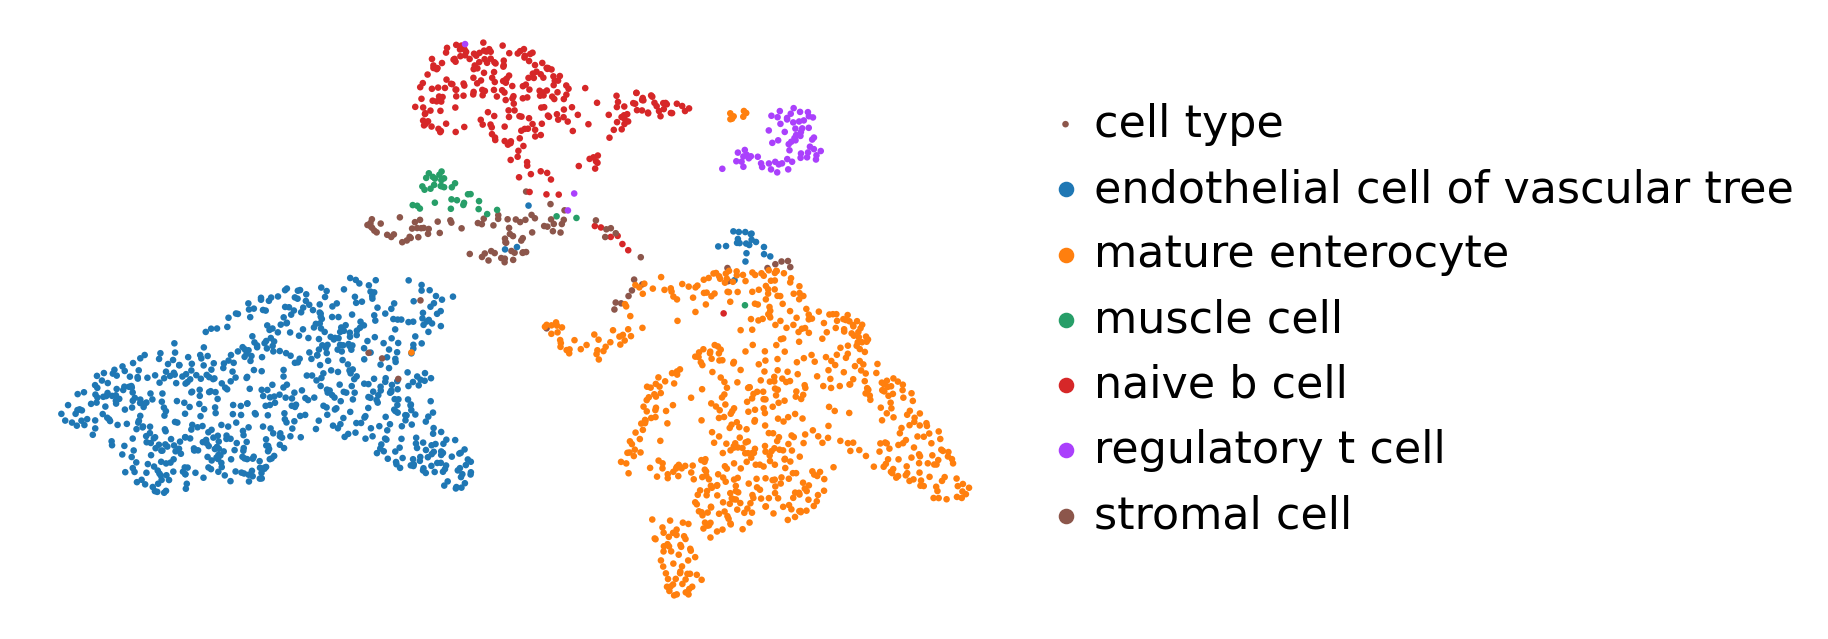

/tmp/ipykernel_1709525/2996577021.py:16: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  SOD2_isoform.obsm['X_umap']=SOD2_gene.obsm['X_umap']


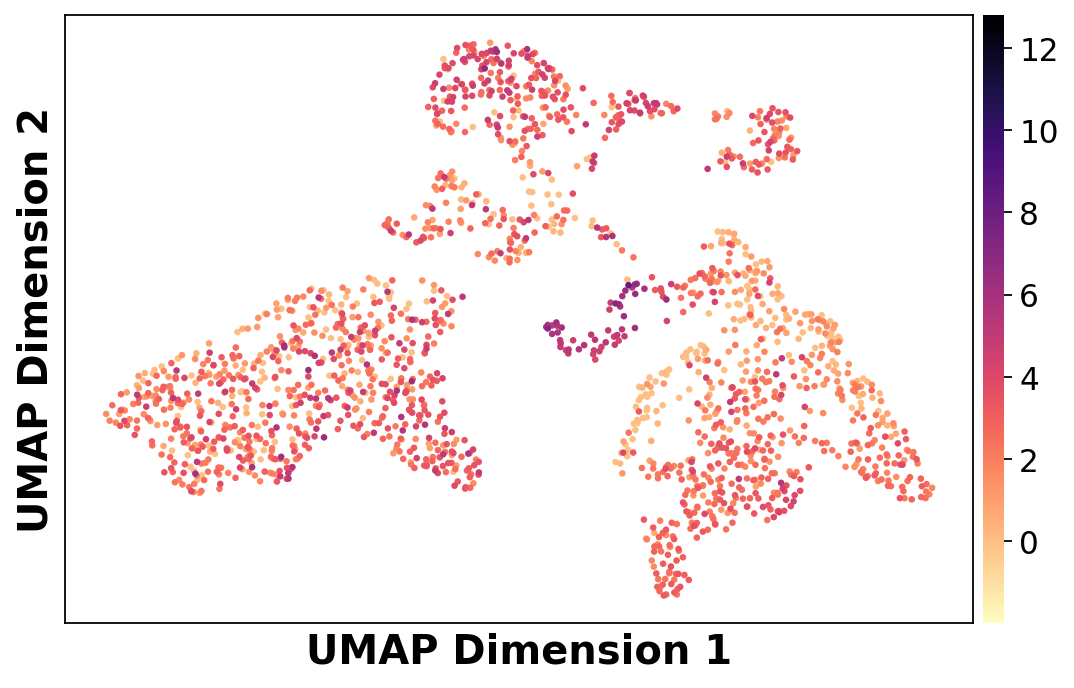

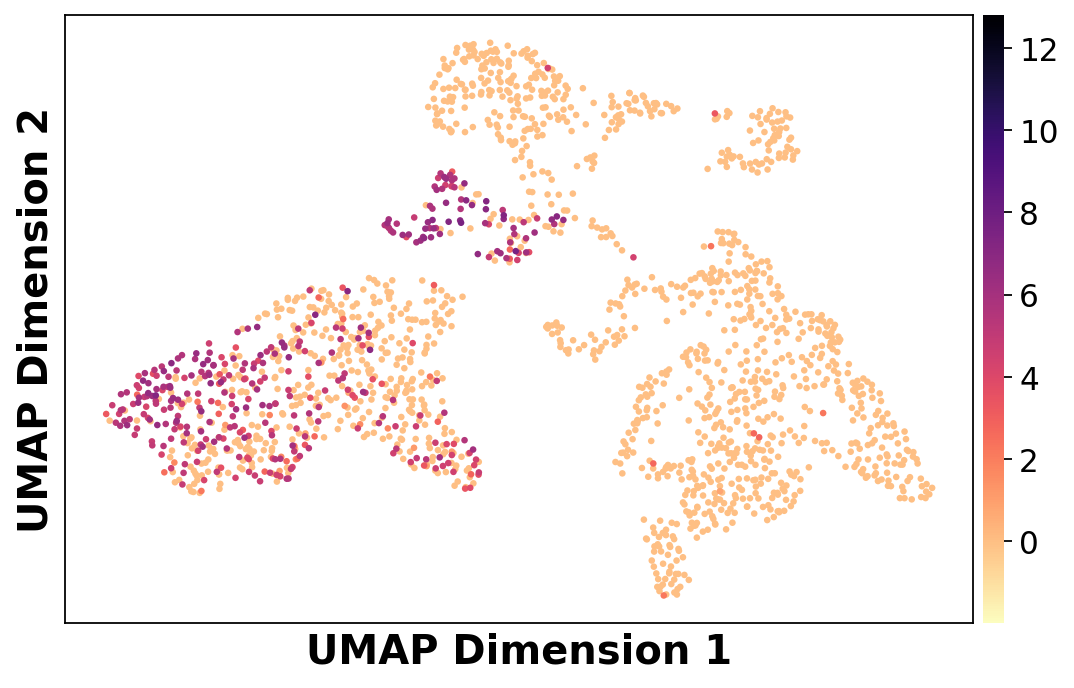

In [123]:
#SOD2 example
SOD2_list=['muscle cell','stromal cell','endothelial cell of vascular tree',
           'naive b cell','mature enterocyte','regulatory t cell']
SOD2_isoform=selected_isoform[selected_isoform.obs['cell_ontology_class'].isin(SOD2_list),:]
index_list=list(SOD2_isoform.obs.index)
SOD2_gene=smartseq2_gene_expression[smartseq2_gene_expression.obs.index.isin(index_list),:]
sc.pp.neighbors(SOD2_gene,n_neighbors=10)
sc.tl.umap(SOD2_gene,min_dist=0.9, spread=1.5)
sc.set_figure_params(figsize =(8,5))
ax=sc.pl.umap(SOD2_gene, color='cell_ontology_class',size=35,title='',show=False,
              legend_fontsize=20,label='cell type')
ax.set_xlabel('UMAP Dimension 1',fontsize=18,weight='bold')
ax.set_ylabel('UMAP Dimension 2',fontsize=18,weight='bold')
plt.show()
#
SOD2_gene = SOD2_gene[SOD2_gene.obs.index.argsort()]
SOD2_isoform = SOD2_isoform[SOD2_isoform.obs.index.argsort()]
SOD2_isoform.obsm['X_umap']=SOD2_gene.obsm['X_umap']
#set the color using the max expression cell in the gene
vmax=np.max(SOD2_isoform.X.todense())+0.1
#
sc.set_figure_params(figsize =(8,5))
ax=sc.pl.umap(SOD2_isoform, color='ENST00000538183.7',size=35,title='',show=False,vmin=-2,vmax=vmax,color_map='magma_r')
cbar = ax.collections[-1].colorbar
cbar.set_ticks(list(range(0, 15, 2)))
cbar.outline.set_visible(False)
ax.set_xlabel('UMAP Dimension 1',fontsize=18,weight='bold')
ax.set_ylabel('UMAP Dimension 2',fontsize=18,weight='bold')
plt.show()
#
sc.set_figure_params(figsize =(8,5))
ax=sc.pl.umap(SOD2_isoform, color='ENST00000337404.8',size=35,title='',show=False,vmin=-2,vmax=vmax,color_map='magma_r')
cbar = ax.collections[-1].colorbar
cbar.set_ticks(list(range(0, 15, 2)))
cbar.outline.set_visible(False)
ax.set_xlabel('UMAP Dimension 1',fontsize=18,weight='bold')
ax.set_ylabel('UMAP Dimension 2',fontsize=18,weight='bold')
plt.show()